In [26]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
import sys
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table

In [28]:
#this function simply uploads the testing and training scans into lists of numpy arrays
#the data is not yet sliced or patched at this stage

#specify in a list what scans to use for training and what scans to use for testing


def get_data(petmr_path, trio_path, scans_dict):
    
    train_data_inp = []
    test_data_inp = []
    train_data_out = []
    test_data_out = []
    paths = [petmr_path, trio_path]
    
    for data_path in paths:
        if(data_path == petmr_path):
            print "Uploading Inputs:"
            training_data_store = train_data_inp
            testing_data_store = test_data_inp
        else:
            print "Uploading Outputs"
            training_data_store = train_data_out
            testing_data_store = test_data_out
        os.chdir(data_path)
        for key, subjs in scans_dict.iteritems():
            for subj_scan in subjs:
                scan_image = nib.load(str(data_path) + "/Subj" + subj_scan + "/Brain_Thresholded.nii.gz")
                scan_data = scan_image.get_data()
                #all scans have the same affine mat because registration has already been performed
                #we only need it for saving the predictions as a NIfTI file
                affine_mat = scan_image.affine
                #get b=0 volumes only
                bvals_scan, bvecs_scan = read_bvals_bvecs(str(data_path) + "/Subj" + subj_scan + "/NODDI.bval",\
                                                          str(data_path) + "/Subj" + subj_scan + "/NODDI.bvec")
                #set a threshold value for b=0 values (due to TRIO dataset)
                gtab_scan = gradient_table(bvals_scan, bvecs_scan, b0_threshold=5)
                s0s_scan = scan_data[:, :, :, gtab_scan.b0s_mask]
            
                if(key == "training"):
                    print ("Training: Subj%s" % subj_scan)
                    #append this data to the list containing the training data
                    training_data_store.append(scan_data)
                else:
                    print ("Testing: Subj%s" % subj_scan)
                    testing_data_store.append(scan_data)
    return (train_data_inp, train_data_out, test_data_inp, test_data_out, affine_mat)

In [29]:
def analysis(scan, title, percentile):
    
    mask = scan>0
    brain = scan[mask]
    
    
    print("maximum: %d" % brain.max())
    print("minimum: %d" % brain.min())
    print("average: %d" % brain.mean())
    print("99th percentile: %d\n" % np.percentile(brain, percentile))

    print("Total number of voxels: %d" % brain.shape[0])
    print("Voxels greater than %d percentile value: %d" % (percentile, (brain>np.percentile(brain,99)).sum()) )

    plt.hist((brain.flatten()), bins = 1024);
    plt.title(title)



In [30]:
#upload the data
petmr_data_path = '/Volumes/Seagate Backup Plus Drive/Project/Dataset/PETMR_data'
trio_data_path = '/Volumes/Seagate Backup Plus Drive/Project/Dataset/TRIO_data'

#training_scans = ["1Scan1", "1Scan2", "2Scan1","2Scan2","3Scan1","3Scan2","4Scan1","4Scan2","5Scan1", \
 #               "5Scan2","6Scan1","6Scan2","7Scan1","7Scan2","8Scan1","8Scan2",]

training_scans = ["1Scan1", "1Scan2"]

testing_scans = ["1Scan1"]

(training_data_inp, training_data_out, testing_data_inp, testing_data_out, affine_mat) = \
        get_data(petmr_data_path, trio_data_path, {"training":training_scans, "testing":testing_scans})

print ("Number of scans used for training input: %d" % len(training_data_inp))
print ("Number of scans used for training output: %d" % len(training_data_out))
print ("Number of scans used for testing input: %d" % len(testing_data_inp))
print ("Number of scans used for testing output: %d" % len(testing_data_out))

Uploading Inputs:
Training: Subj1Scan1
Training: Subj1Scan2
Testing: Subj1Scan1
Uploading Outputs
Training: Subj1Scan1
Training: Subj1Scan2
Testing: Subj1Scan1
Number of scans used for training input: 2
Number of scans used for training output: 2
Number of scans used for testing input: 1
Number of scans used for testing output: 1


------------------------------------------------------------------------------------------------------------
--

------------------------------------------------------------------------------------------------------------
--

In [31]:
x = training_data_inp[0]
y = training_data_inp[1]

maximum: 2114
minimum: 9
average: 379
99th percentile: 1297

Total number of voxels: 61910
Voxels greater than 99 percentile value: 619


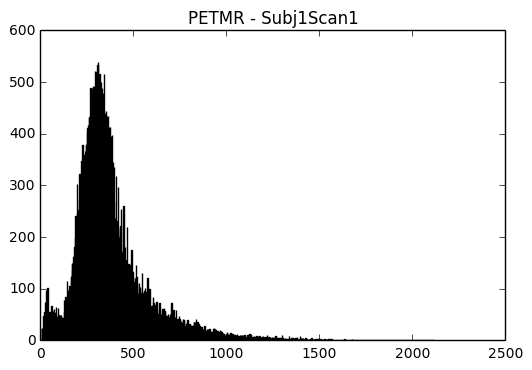

In [32]:
analysis(x[:,:,:,0], "PETMR - Subj1Scan1", 99.5)

maximum: 2114
minimum: 5
average: 381
99th percentile: 1314

Total number of voxels: 62924
Voxels greater than 99 percentile value: 630


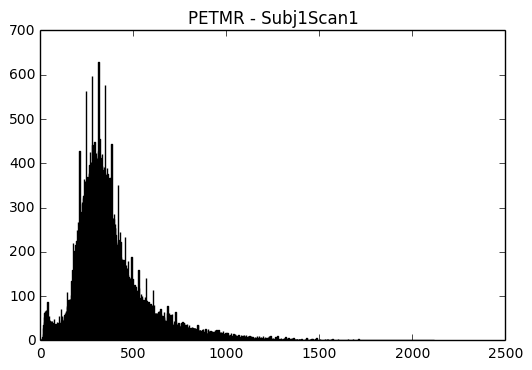

In [33]:
analysis(y[:,:,:,0], "PETMR - Subj1Scan1", 99.5)

maximum: 4095
minimum: 1
average: 158
99th percentile: 967

Total number of voxels: 7360463
Voxels greater than 99 percentile value: 73456


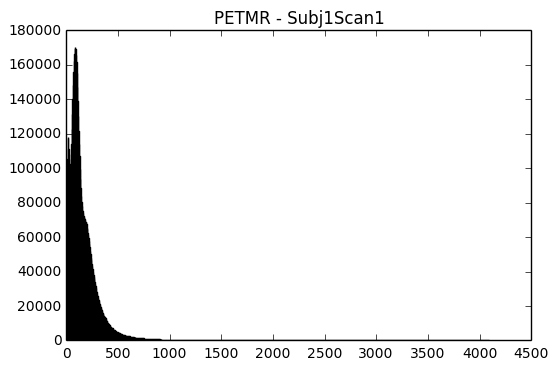

In [15]:
analysis(testing_data_inp[0], "PETMR - Subj1Scan1", 99.5)

maximum: 1662
minimum: 2
average: 298
99th percentile: 897

Total number of voxels: 818298
Voxels greater than 99 percentile value: 8154


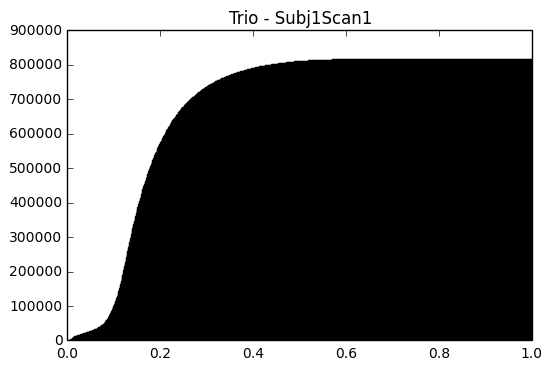

In [10]:
analysis(testing_data_out[0], "Trio - Subj1Scan1", 99.5)

maximum: 3499
minimum: 1
average: 393
99th percentile: 1639

Total number of voxels: 1044028
Voxels greater than 99 percentile value: 10415


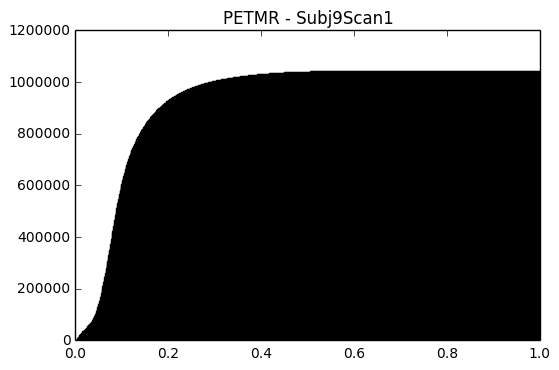

In [11]:
analysis(testing_data_inp[1], "PETMR - Subj9Scan1", 99.5)

maximum: 3376
minimum: 3
average: 354
99th percentile: 1325

Total number of voxels: 1044160
Voxels greater than 99 percentile value: 10405


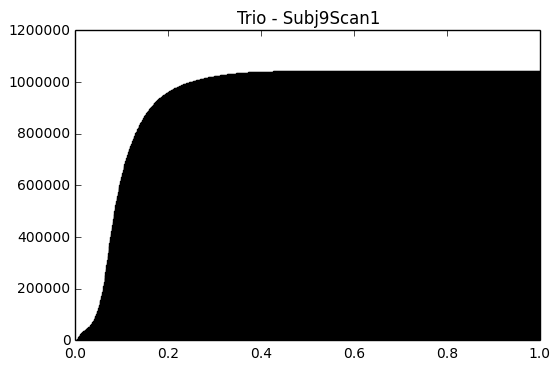

In [12]:
analysis(testing_data_out[1], "Trio - Subj9Scan1", 99.5)

In [13]:
capped = testing_data_out[1]
capped[capped>1170] = 1170

In [14]:
save_to = "/Volumes/Seagate Backup Plus Drive/Project/Dataset/TRIO_data/Subj9Scan1"

capped_scan = nib.Nifti1Image(capped, affine_mat)
nib.save(capped_scan, save_to + "/Capped_Scan.nii.gz" )

maximum: 1662
minimum: 2
average: 298
99th percentile: 897

Total number of voxels: 818298
Voxels greater than 99 percentile value: 8154


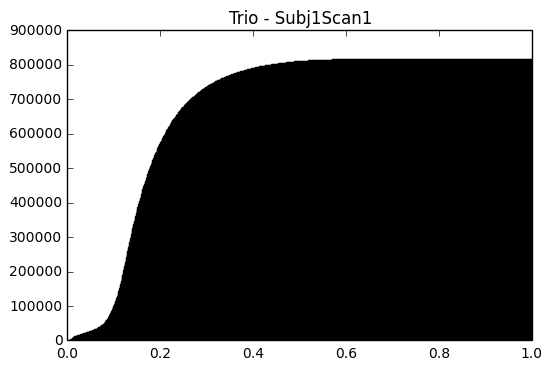

In [15]:
analysis(testing_data_out[0], "Trio - Subj1Scan1", 99.5)

maximum: 1170
minimum: 3
average: 351
99th percentile: 1170

Total number of voxels: 1044160
Voxels greater than 99 percentile value: 0


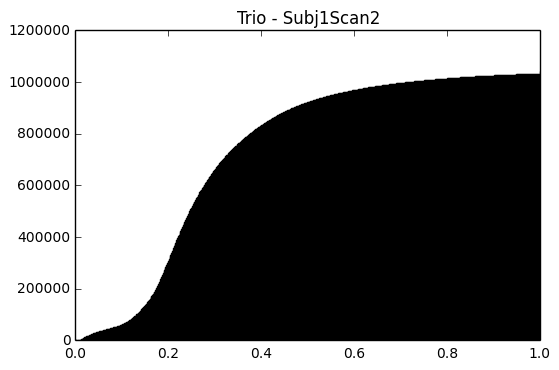

In [16]:
analysis(testing_data_out[1], "Trio - Subj1Scan2", 99.5)

# Histogram Matching

In [34]:
def viz_pred(source, template, matched, sliceNo, scale):
    if scale == False:
        plt.figure
        plt.figure(figsize=(10,10))
        plt.subplot(1, 3, 1).set_axis_off()
        plt.imshow(source[:,:,sliceNo].T, cmap='gray', origin='lower')
        plt.title("Source")
        plt.subplot(1, 3, 2).set_axis_off()
        plt.imshow(template[:,:,sliceNo].T, cmap='gray', origin='lower')
        plt.title("Template")
        plt.subplot(1, 3, 3).set_axis_off()
        plt.imshow(matched[:,:,sliceNo].T, cmap='gray', origin='lower')
        plt.title("Matched")
        plt.show()
    else:
        max1 = np.max(source)
        max2 = np.max(template)
        if max1 > max2:
            maximum = max1
        else:
            maximum = max2
        plt.figure
        plt.figure(figsize=(10,10))
        plt.subplot(1, 3, 1).set_axis_off()
        plt.imshow(source[:,:,sliceNo].T, cmap='gray', origin='lower', vmax = maximum, vmin=0)
        plt.title("Source")
        plt.subplot(1, 3, 2).set_axis_off()
        plt.imshow(template[:,:,sliceNo].T, cmap='gray', origin='lower', vmax = maximum, vmin=0)
        plt.title("Template")
        plt.subplot(1, 3, 3).set_axis_off()
        plt.imshow(matched[:,:,sliceNo].T, cmap='gray', origin='lower', vmax = maximum, vmin=0)
        plt.title("Matched")
        plt.show()

In [35]:

brain_template = training_data_inp[0][:,:,:,0]


brain_source = training_data_inp[1][:,:,:,0]

In [36]:
def hist_match(source, template):

    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    
    #bin_idx returns the index of the unique element in terms of the unique array
    #returns the index of a value in s_values
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True, return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)
    
    # remove the first element from s_counts, t_counts and t_values as these values correspond to 0 intensity
    # we do not want to consider backgroung voxels

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts[1:]).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts[1:]).astype(np.float64)
    t_quantiles /= t_quantiles[-1]
    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    print s_quantiles
    print t_quantiles
    print t_values[1:]
    print s_values[1:]
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values[1:])
    print interp_t_values
    
    # the interpoltaed values do not contain the intensity value 0
    # add this to the start of the list
    interp_t_values = np.insert(interp_t_values, 0, 0)
    
    
    fig=plt.figure()
    plt.plot(s_values[1:], s_quantiles * 100, '-r', lw=3, label='Source')
    plt.plot(t_values[1:], t_quantiles * 100, '-k', lw=3, label='Template')
    plt.plot(interp_t_values[1:], s_quantiles * 100, '--r', lw=3, label='Matched')
    #plt.xlim(s_values[1], s_values[-1])
    plt.xlabel('voxel intensity')
    plt.ylabel('Cumulative %')
    plt.legend(loc=5)

    return interp_t_values[bin_idx].reshape(oldshape)

[  1.58921874e-05   6.35687496e-05   9.53531244e-05 ...,   9.99968216e-01
   9.99984108e-01   1.00000000e+00]
[  1.13067356e-04   3.55354547e-04   5.81489259e-04 ...,   9.99967695e-01
   9.99983848e-01   1.00000000e+00]
[    9.59256077    11.63962078    13.23937988 ...,  1961.76208496
  2009.95910645  2114.63061523]
[    5.0005827      8.00041771     9.0005312  ...,  2061.9831543
  2093.95898438  2114.9921875 ]
[    9.59256077     9.59256077     9.59256077 ...,  1963.31544393
  2011.64585411  2114.63061523]


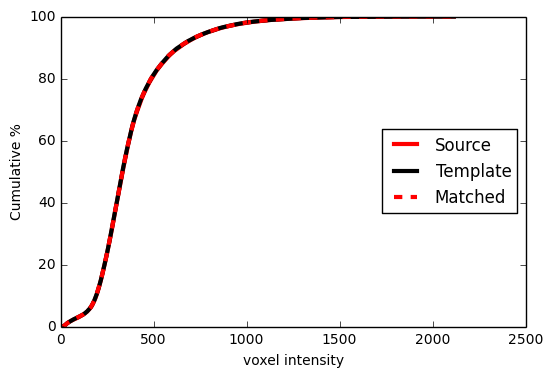

In [37]:
test = hist_match(brain_source, brain_template)

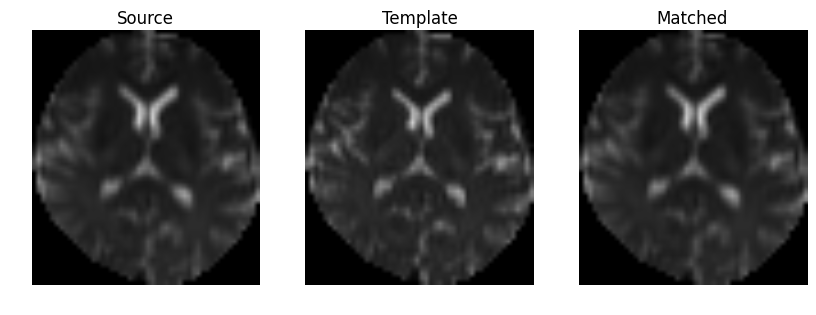

In [38]:
viz_pred(brain_source, brain_template, test, 25, scale=True)